 ## correlation between temperature and the center of birds distribution in Eastern America
 1. Region: Eastern America
2. Bird specie: American Goldfinch("NABBP_2023_grp_39.csv")
3. Temperature: average monthly temperature from 1962-2018 in Eastern America
4. Center: (Longitude, Latitude)
5. model: linear regression( I tried some more complex models, but this performed best)
6. Conclusion: When temperatures rise in New York, American Goldfinches tend to shift northward and eastward.

In [11]:
import pandas as pd
from scipy.stats import mode
from geopy.geocoders import Nominatim
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from collections import OrderedDict
from scipy.optimize import minimize
import sklearn 
import math
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

### data clean

In [13]:
columns_to_load = [ "EVENT_DAY", "EVENT_YEAR", "EVENT_MONTH",
                   'ISO_COUNTRY', 'ISO_SUBDIVISION','LAT_DD','LON_DD']
df = pd.read_csv("NABBP_2023_grp_39.csv", usecols=columns_to_load)
filtered_df = df[(df['ISO_COUNTRY'] == 'US')
                  &(1 <= df['EVENT_MONTH']) 
                  & (df['EVENT_MONTH'] <= 12) 
                 ].dropna()

In [14]:
filtered_df['ISO_SUBDIVISION'] = filtered_df['ISO_SUBDIVISION'].str[3:]

In [15]:
filtered_df.isna().sum()

EVENT_DAY          0
EVENT_MONTH        0
EVENT_YEAR         0
ISO_COUNTRY        0
ISO_SUBDIVISION    0
LAT_DD             0
LON_DD             0
dtype: int64

In [16]:
grouped_by_states = filtered_df.groupby('ISO_SUBDIVISION')

In [17]:
count_by_state = {}
for state, group in grouped_by_states:
    count_by_state[state] = len(group)

In [18]:
sorted_by_count = OrderedDict(sorted(count_by_state.items(), key=lambda x: x[1], reverse=True))

In [19]:
sorted_by_count

OrderedDict([('MI', 146835),
             ('NY', 112149),
             ('PA', 108768),
             ('WI', 102387),
             ('OH', 102047),
             ('MD', 85710),
             ('TX', 77128),
             ('MN', 68650),
             ('IL', 53540),
             ('WV', 40484),
             ('IA', 39720),
             ('KS', 38168),
             ('VA', 33271),
             ('IN', 28676),
             ('MA', 28372),
             ('NJ', 26709),
             ('TN', 25448),
             ('CA', 24854),
             ('MO', 23566),
             ('NE', 22057),
             ('CT', 19040),
             ('SC', 18896),
             ('OK', 17275),
             ('AL', 14213),
             ('OR', 11852),
             ('ME', 10166),
             ('SD', 9726),
             ('NC', 8395),
             ('GA', 7497),
             ('VT', 6916),
             ('FL', 5056),
             ('LA', 4412),
             ('AR', 4192),
             ('NH', 3990),
             ('CO', 3691),
             ('KY', 3649

### choose the region

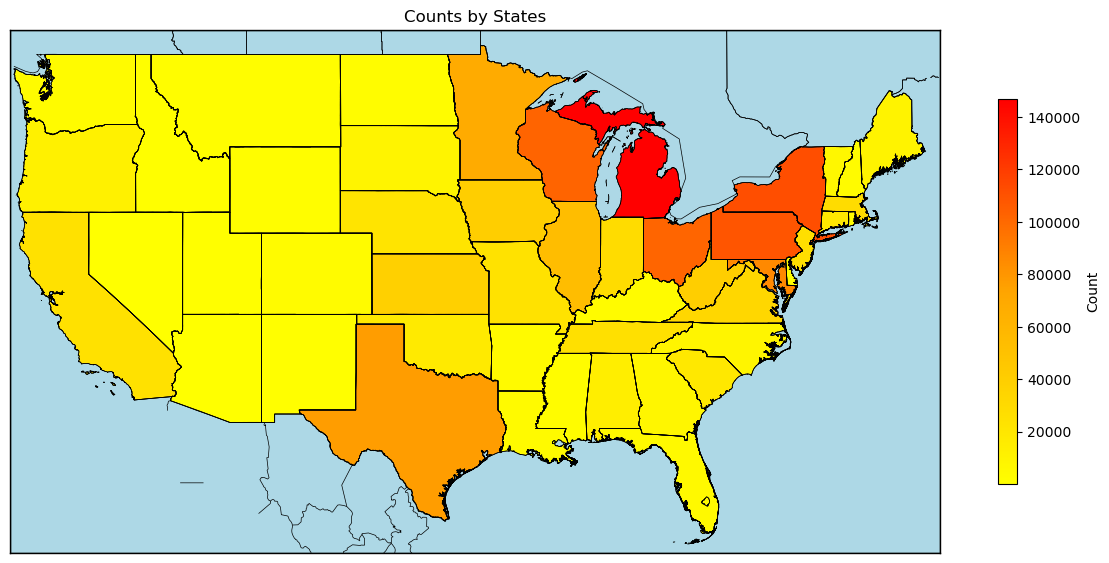

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(projection='merc', llcrnrlat=24, urcrnrlat=50, llcrnrlon=-125, urcrnrlon=-66, resolution='i', ax=ax)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue', zorder=0)
m.drawcountries()
m.drawstates()


shp_info = m.readshapefile('s_05mr24', name='states', drawbounds=True)

colors = ['yellow', 'orange','red']
cmap = mcolors.LinearSegmentedColormap.from_list(_,colors)

norm = mcolors.Normalize(vmin=min(sorted_by_count.values()), vmax=max(sorted_by_count.values()))


for info, shape in zip(m.states_info, m.states):
    state_abbr = info['STATE']
    if state_abbr in sorted_by_count:
        count = sorted_by_count[state_abbr]
        color = cmap(norm(count))
    else:
        color = 'white'  
    poly = plt.Polygon(shape, facecolor=color, edgecolor='black', linewidth=0.5)
    ax.add_patch(poly)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, aspect=20, label='Count')

plt.title('Counts by States')
plt.show()

Conclusion: American Goldfinches mostly live in Eastern America. So we choose American Goldfinches live in Eastern America to analyse.

### load temperature data and location data


In [151]:
grouped_by_year = filtered_df.groupby('EVENT_YEAR')

In [152]:
years = []
for year, group in grouped_by_year:
    print(f"Year: {year}")
    print(len(group))
    years.append(year)

Year: 1960
9903
Year: 1961
7744
Year: 1962
12406
Year: 1963
19144
Year: 1964
19831
Year: 1965
14763
Year: 1966
14800
Year: 1967
14277
Year: 1968
14083
Year: 1969
18565
Year: 1970
16511
Year: 1971
25210
Year: 1972
22965
Year: 1973
20403
Year: 1974
19610
Year: 1975
21242
Year: 1976
18231
Year: 1977
29697
Year: 1978
31550
Year: 1979
29360
Year: 1980
33652
Year: 1981
30543
Year: 1982
39387
Year: 1983
41701
Year: 1984
34209
Year: 1985
36589
Year: 1986
28394
Year: 1987
29652
Year: 1988
27246
Year: 1989
27669
Year: 1990
24906
Year: 1991
18743
Year: 1992
22390
Year: 1993
24536
Year: 1994
16349
Year: 1995
20628
Year: 1996
23321
Year: 1997
21950
Year: 1998
17502
Year: 1999
27620
Year: 2000
21460
Year: 2001
27521
Year: 2002
21770
Year: 2003
22070
Year: 2004
27218
Year: 2005
25784
Year: 2006
19638
Year: 2007
26758
Year: 2008
24375
Year: 2009
23740
Year: 2010
22100
Year: 2011
22336
Year: 2012
16240
Year: 2013
18704
Year: 2014
21754
Year: 2015
15461
Year: 2016
15368
Year: 2017
13173
Year: 2018
11742

In [200]:
# temperatures = [
#     27.6, 25.1, 38.6, 48.7, 56.8, 67.5, 73.0, 69.8, 61.5, 57.9, 48.6, 27.7,
#     31.6, 29.9, 39.0, 46.4, 60.3, 67.3, 72.2, 68.8, 64.9, 53.1, 46.0, 34.1,
#     26.4, 29.4, 36.6, 46.5, 61.3, 66.7, 71.2, 73.5, 67.4, 54.9, 45.1, 38.1,
#     30.0, 29.3, 36.6, 43.4, 53.0, 67.9, 77.0, 74.9, 66.3, 54.9, 46.5, 33.8,
#     33.8, 27.3, 33.5, 44.8, 51.1, 67.2, 73.7, 72.2, 65.4, 56.3, 41.0, 35.9,
#     25.5, 27.9, 40.2, 51.7, 58.0, 67.1, 75.0, 73.3, 68.1, 58.8, 45.4, 32.4,
#     30.5, 29.8, 37.0, 50.7, 59.8, 67.9, 71.6, 73.3, 64.9, 54.7, 45.0, 32.6,
#     23.8, 31.5, 37.0, 49.3, 59.5, 66.9, 74.3, 73.6, 67.1, 57.5, 47.7, 32.6,
#     26.2, 32.9, 38.1, 47.0, 57.2, 69.4, 73.5, 72.2, 69.0, 60.2, 43.4, 38.5,
#     33.0, 29.9, 37.2, 46.0, 59.0, 65.3, 74.1, 72.8, 67.3, 51.2, 41.8, 35.0,
#     30.4, 29.2, 42.0, 49.1, 55.5, 70.4, 75.2, 75.8, 67.9, 59.9, 48.0, 37.6,
#     33.0, 29.5, 40.0, 52.2, 58.4, 68.6, 76.1, 75.1, 65.6, 52.9, 46.5, 37.4,
#     35.2, 32.2, 36.8, 44.7, 61.8, 67.2, 74.4, 74.0, 64.4, 58.9, 50.5, 35.5,
#     26.9, 36.3, 40.2, 51.1, 56.8, 70.3, 71.5, 73.1, 65.4, 53.5, 42.3, 29.9,
#     23.7, 31.2, 41.8, 49.1, 60.4, 65.1, 72.6, 74.0, 67.8, 56.9, 50.0, 33.5,
#     26.6, 24.1, 35.5, 46.9, 56.8, 66.4, 73.2, 75.0, 64.1, 55.4, 47.2, 36.2,
#     30.5, 24.5, 43.0, 49.4, 61.6, 66.6, 73.7, 72.7, 64.8, 53.2, 47.3, 37.9,
#     31.7, 28.0, 37.0, 48.1, 60.4, 67.3, 75.7, 75.9, 68.4, 55.4, 43.2, 31.3,
#     22.1, 33.9, 38.0, 49.3, 58.6, 68.0, 73.9, 71.4, 62.8, 50.5, 44.1, 33.8,
#     23.1, 32.8, 37.9, 46.3, 59.6, 63.9, 72.9, 69.2, 64.0, 52.9, 47.0, 38.7,
#     31.4, 32.2, 40.5, 48.1, 55.7, 67.7, 74.3, 73.0, 67.3, 55.1, 46.5, 33.1,
#     26.5, 36.5, 34.1, 47.9, 57.7, 71.0, 73.0, 74.8, 63.3, 57.7, 45.0, 40.2,
#     26.2, 32.3, 41.7, 50.8, 60.9, 65.6, 73.6, 72.7, 66.6, 56.0, 46.6, 31.4,
#     30.6, 29.1, 39.8, 50.6, 61.1, 66.8, 73.1, 70.6, 64.7, 54.2, 42.3, 35.5,
#     30.0, 30.0, 41.3, 50.2, 58.8, 68.6, 74.9, 71.0, 65.2, 51.3, 44.9, 36.8,
#     26.4, 31.2, 39.4, 48.1, 59.4, 68.2, 75.4, 75.5, 64.6, 50.5, 45.8, 32.7,
#     33.8, 31.0, 38.8, 47.9, 59.5, 68.5, 71.8, 71.6, 65.2, 54.9, 43.2, 23.3,
#     36.7, 35.0, 40.1, 49.2, 56.9, 69.1, 73.9, 73.9, 65.6, 59.6, 46.6, 40.0,
#     31.7, 36.2, 42.2, 51.8, 64.4, 70.3, 75.4, 74.8, 65.1, 56.7, 45.9, 36.7,
#     32.2, 33.8, 37.1, 46.5, 58.0, 67.1, 71.1, 70.4, 64.9, 52.1, 44.7, 36.0,
#     33.6, 27.8, 36.6, 49.2, 61.4, 70.0, 76.7, 75.3, 65.7, 53.3, 45.0, 35.5,   # 1993
#     23.4, 26.1, 37.5, 50.6, 58.6, 71.7, 78.4, 72.0, 65.4, 54.9, 48.9, 38.7,   # 1994
#     35.6, 29.3, 41.3, 48.1, 58.5, 68.8, 77.0, 74.8, 66.1, 58.6, 41.6, 30.1,   # 1995
#     28.4, 30.8, 36.1, 48.7, 57.4, 68.2, 71.2, 72.5, 66.2, 54.0, 40.7, 39.1,  # 1996
#     30.2, 37.3, 38.7, 48.0, 56.1, 67.7, 73.1, 71.5, 65.1, 53.9, 42.2, 35.5,   # 1997
#     36.7, 37.8, 41.0, 49.3, 60.9, 66.8, 73.7, 74.1, 67.4, 55.1, 45.6, 39.2,   # 1998
#     31.0, 34.2, 39.7, 49.7, 59.5, 70.1, 77.3, 72.7, 67.2, 53.7, 47.9, 37.7,   # 1999
#     28.6, 33.9, 43.2, 47.5, 59.6, 68.5, 70.4, 70.8, 64.4, 53.9, 43.6, 29.6,   # 2000
#     29.5, 32.2, 36.5, 49.5, 60.3, 71.0, 71.6, 75.8, 66.0, 56.1, 49.2, 41.4,   # 2001
#     36.4, 36.8, 40.6, 51.3, 57.2, 68.7, 76.0, 74.9, 67.8, 53.7, 42.9, 33.7,   # 2002
#     25.9, 26.9, 38.0, 45.9, 56.2, 66.6, 73.9, 75.6, 67.0, 53.8, 47.5, 35.0,   # 2003
#     21.9, 32.2, 40.0, 49.9, 60.5, 68.2, 73.2, 72.8, 68.8, 56.5, 47.6, 36.4,   # 2004
#     29.6, 34.5, 37.1, 51.4, 55.5, 70.4, 74.9, 76.3, 69.8, 56.3, 46.5, 33.3,   # 2005
#     36.6, 32.4, 39.6, 51.0, 58.7, 68.9, 76.4, 73.6, 64.8, 54.5, 49.2, 41.0,   # 2006
#     34.8, 26.9, 37.6, 47.3, 61.1, 68.8, 73.1, 72.8, 67.5, 61.4, 44.6, 35.7,   # 2007
#     34.6, 33.9, 40.4, 51.3, 58.4, 72.2, 76.7, 71.8, 67.3, 53.4, 44.0, 35.4,   # 2008
#     25.2, 33.4, 38.0, 50.1, 58.8, 65.6, 71.2, 74.6, 64.9, 53.1, 49.0, 33.3,   # 2009
#     29.7, 32.5, 45.0, 53.9, 62.1, 71.8, 78.0, 75.1, 69.3, 56.5, 45.7, 31.3,   # 2010
# ]

temperatures = np.genfromtxt("temperature.csv", delimiter=',', skip_header=1, usecols=[1])
temperatures = temperatures[1:]
print(temperatures[:100])

[27.3 29.7 37.6 48.7 63.1 68.1 69.6 69.7 61.1 53.7 39.5 27.7 25.1 23.6
 40.9 50.2 58.3 67.8 71.5 68.4 60.5 56.2 44.5 24.1 29.8 28.  39.7 49.6
 61.8 68.2 72.2 67.8 62.9 49.9 44.5 33.5 27.3 29.6 36.1 48.2 63.5 66.6
 70.  70.  65.1 50.9 41.8 34.6 25.5 29.8 39.9 47.2 57.2 67.6 72.8 70.2
 61.5 51.  43.4 31.8 32.9 26.2 38.3 50.5 54.3 68.6 70.8 69.  60.6 52.2
 38.1 34.4 23.7 24.8 40.9 51.7 57.1 67.2 72.3 71.2 64.5 54.4 41.8 29.2
 27.1 30.  35.3 50.8 59.5 68.6 72.3 70.3 63.1 52.5 40.7 29.  21.2 29.4
 36.7 50.5]


In [201]:

len(temperatures) == 12 * (2018-1962+1)


True

In [209]:
eastern_states = [
    'ME', 'VT', 'NH', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA',
    'DE', 'MD', 'DC', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'AL', 'TN', 'KY'
]
grouped_by_month = filtered_df[(1962 <= filtered_df['EVENT_YEAR']) 
                                & (filtered_df['EVENT_YEAR'] <= 2018)
                                & (filtered_df['ISO_SUBDIVISION'].isin(eastern_states))].groupby(["EVENT_YEAR", "EVENT_MONTH"])

In [210]:
grouped_by_month.size()

EVENT_YEAR  EVENT_MONTH
1962        1               874
            2              1057
            3              1966
            4              2194
            5               633
                           ... 
2018        8               119
            9               340
            10              589
            11              992
            12              165
Length: 684, dtype: int64

In [211]:
### use mode as center
def calculate_mode(series):
    return mode(series, nan_policy='omit')[0]

def find_mode(grouped_by_month):
    mode_results = grouped_by_month[['LAT_DD', 'LON_DD']].apply(
        lambda group: pd.Series({
            'LAT_DD_mode': calculate_mode(group['LAT_DD']),
            'LON_DD_mode': calculate_mode(group['LON_DD'])
        })
    )
    
    return mode_results['LAT_DD_mode'].tolist(), mode_results['LON_DD_mode'].tolist()

lat_dd_modes, lon_dd_modes = find_mode(grouped_by_month)

use weiszfeld_algorithm to calculate the centers

In [212]:
def distance(coord1, coord2):  
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

def weiszfeld_algorithm(grouped_by_month, max_iter=100, tol=1e-6, min_dist=1e-5):
    
    def update_center(points, current_center):
        distances = np.linalg.norm(points - current_center, axis=1)
        
        weights = 1 / (distances + min_dist)  
        weights = np.nan_to_num(weights, nan=0.0, posinf=0.0)  
        
        new_center = np.sum(weights[:, None] * points, axis=0) / np.sum(weights)
        return new_center

    centers = []
    for group_keys, group_data in grouped_by_month:
        points = group_data[['LON_DD', 'LAT_DD']].to_numpy()
        
        if len(points) == 0:
            print(f"Warning: No data for group {group_keys}")
            centers.append(None)
            continue
        
        current_center = np.mean(points, axis=0)
        
        for iteration in range(max_iter):
            new_center = update_center(points, current_center)
            diff = np.linalg.norm(new_center - current_center)

            if diff < tol:

                break

            current_center = new_center

        centers.append(current_center)
    
    
    return centers
    

In [213]:
centers = weiszfeld_algorithm(grouped_by_month)
centers_lon = [i[0] for i in centers]
centers_lat = [i[1] for i in centers]

In [288]:
len(centers_lon) == len(centers_lat) == len(temperatures)

True

### graph

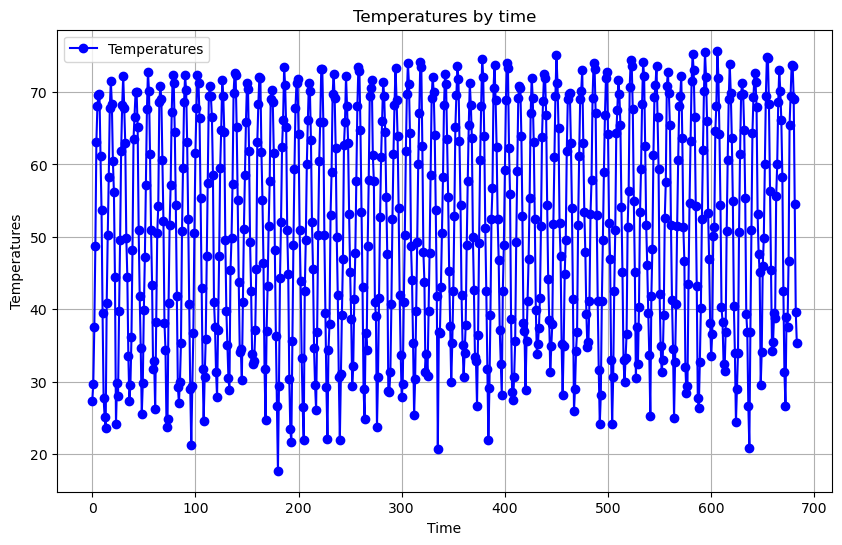

In [216]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, label='Temperatures', color='blue', marker='o')

plt.xlabel('Time')
plt.ylabel('Temperatures')
plt.title('Temperatures by time')

plt.legend()

plt.grid(True)

plt.show()

In [217]:
combinations = list(zip(temperatures, centers_lat, centers_lon))
sorted_combinations = sorted(combinations, key=lambda x: x[0])
sorted_temperatures = [i[0] for i in sorted_combinations]
sorted_lat = [i[1] for i in sorted_combinations]
sorted_lon = [i[2] for i in sorted_combinations]

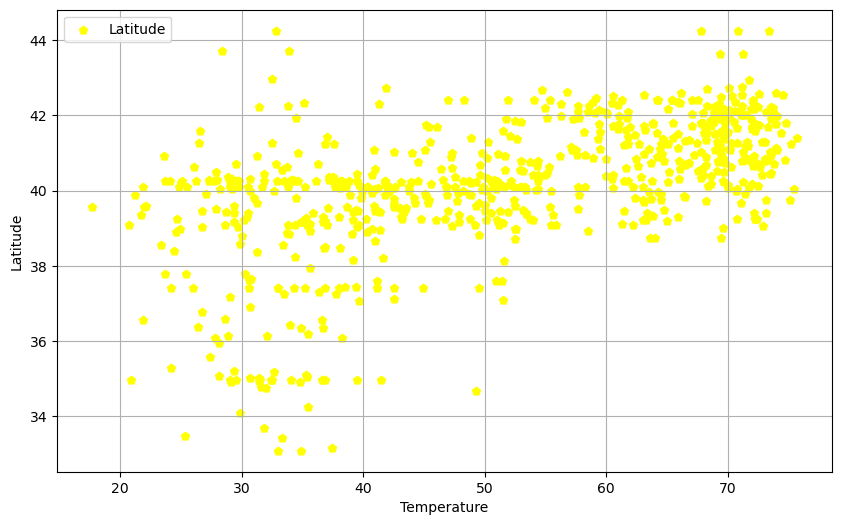

In [218]:
plt.figure(figsize=(10, 6))
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

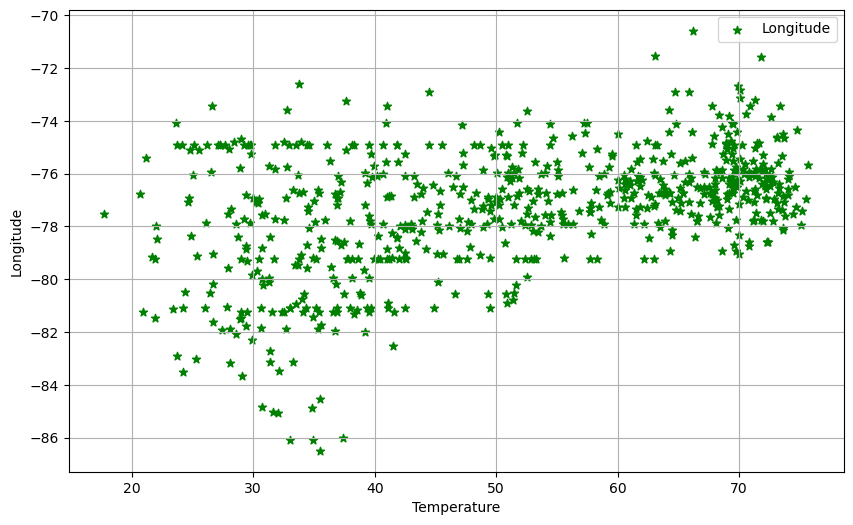

In [219]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_temperatures, sorted_lon, label='Longitude', color='green', marker='*')
plt.xlabel('Temperature')
plt.ylabel('Longitude')


plt.legend()
plt.grid(True)
plt.show()

### Mutual Information

In [220]:
mi_lon = mutual_info_regression(np.array(sorted_temperatures)[:,None], np.array(sorted_lon))

In [221]:
mi_lon

array([0.22623402])

In [222]:
mi_lat = mutual_info_regression(np.array(sorted_temperatures)[:, None], np.array(sorted_lat))

In [223]:
mi_lat

array([0.28578694])

Conclusion: Latitude and temperature, longitude and temperature  both have a positive correlation.

### Pearson Correlation Coefficient-linear


In [325]:
np.corrcoef(sorted_temperatures, sorted_lat)[0, 1]

0.5609717226676407

In [326]:
np.corrcoef(sorted_temperatures, sorted_lon)[0, 1]

0.43482183398112256

Conclusion: Latitude and temperature, longitude and temperature  both have a positive linear correlation.

### regression analysis of latitude and temperature 

#### use temperature as feature

In [224]:
def MSE(preds,labels):
    numer = 0
    for pred, label in zip(preds, labels):
        numer += (pred-label)**2
    return numer/len(labels)
        

In [225]:
features = list(zip([1]*len(sorted_temperatures),sorted_temperatures))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lat)

LinearRegression()

In [226]:
preds = model.predict(features)

In [227]:
X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), X])
y = model.predict(feature) 

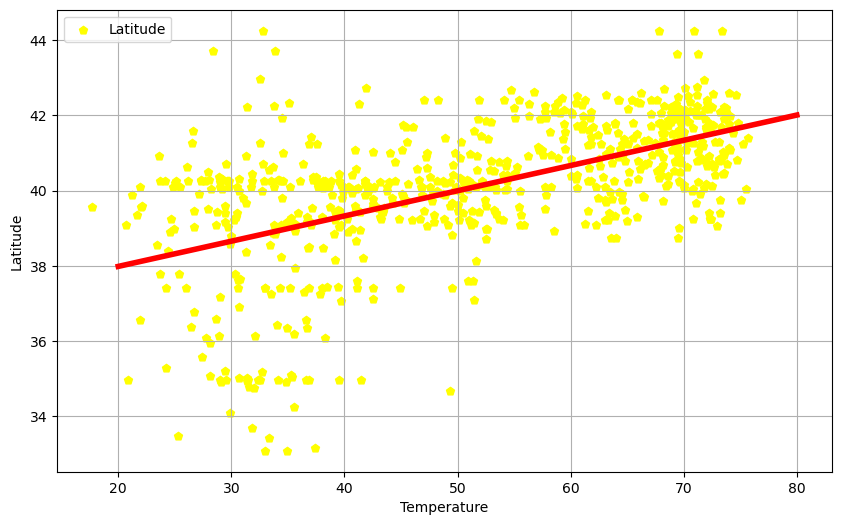

In [228]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red',linewidth=4)
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

In [229]:
MSE(preds,sorted_lat)

2.3993354499279707

#### use ln(temperature) as feature

In [266]:
ln_temperature = [math.log(i) for i in sorted_temperatures]

In [267]:
features = list(zip([1]*len(ln_temperature),ln_temperature))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lat)
preds = model.predict(features)

In [268]:

X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), np.log(X)])
y = model.predict(feature) 

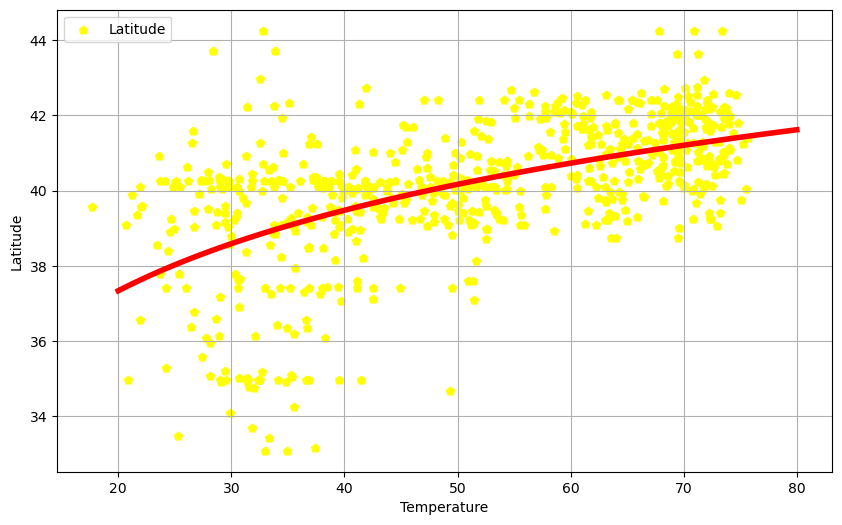

In [269]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red',linewidth=4)
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

In [270]:
MSE(preds,sorted_lat)

2.4289774889744473

### regression analysis of longitude and temperature

In [237]:
features = list(zip([1]*len(sorted_temperatures),sorted_temperatures))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lon)

LinearRegression()

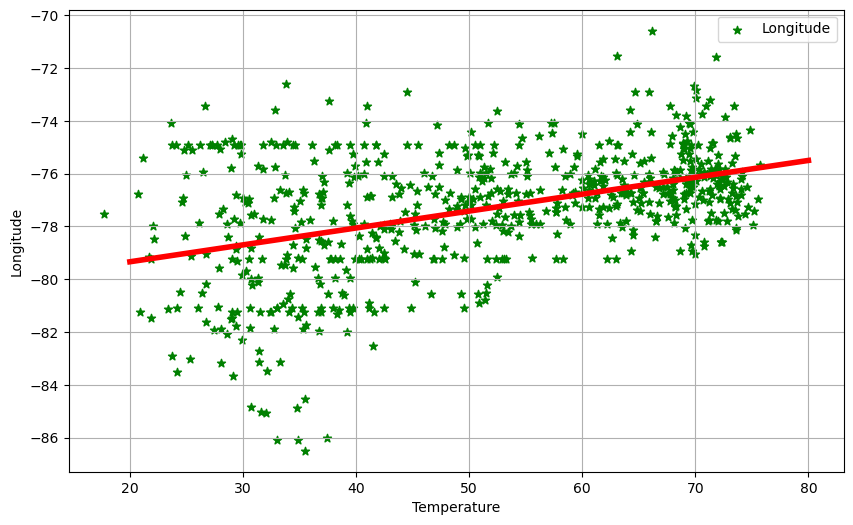

In [239]:
preds = model.predict(features)
X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), X])
y = model.predict(feature)
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red', linewidth=4)
plt.scatter(sorted_temperatures, sorted_lon, label='Longitude', color='green', marker='*')
plt.xlabel('Temperature')
plt.ylabel('Longitude')

plt.legend()
plt.grid(True)
plt.show()


In [240]:
MSE(preds, sorted_lon)

4.300632575859366

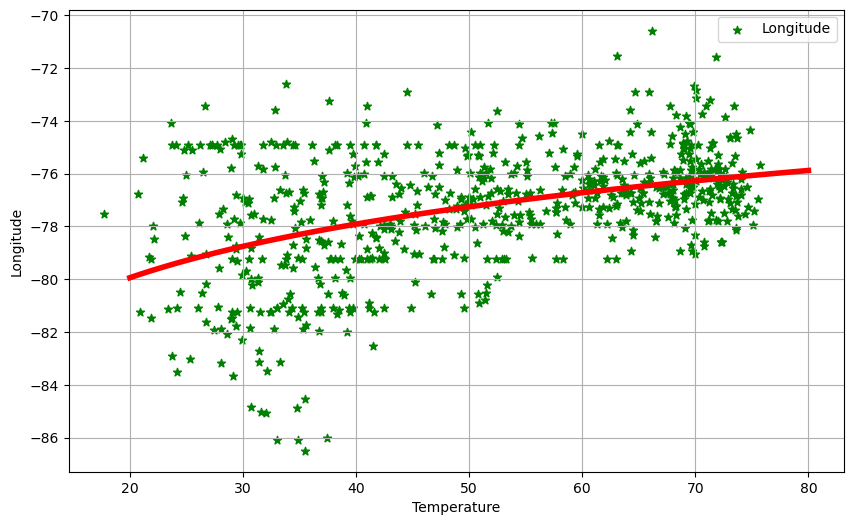

In [241]:
ln_temperature = [math.log(i) for i in sorted_temperatures]
features = list(zip([1] * len(ln_temperature), ln_temperature))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lon)
X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), np.log(X)])
y = model.predict(feature)
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red', linewidth=4)
plt.scatter(sorted_temperatures, sorted_lon, label='Longitude', color='green', marker='*')
plt.xlabel('Temperature')
plt.ylabel('Longitude')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
preds = model.predict(features)
MSE(preds, sorted_lon)

### Center migration route

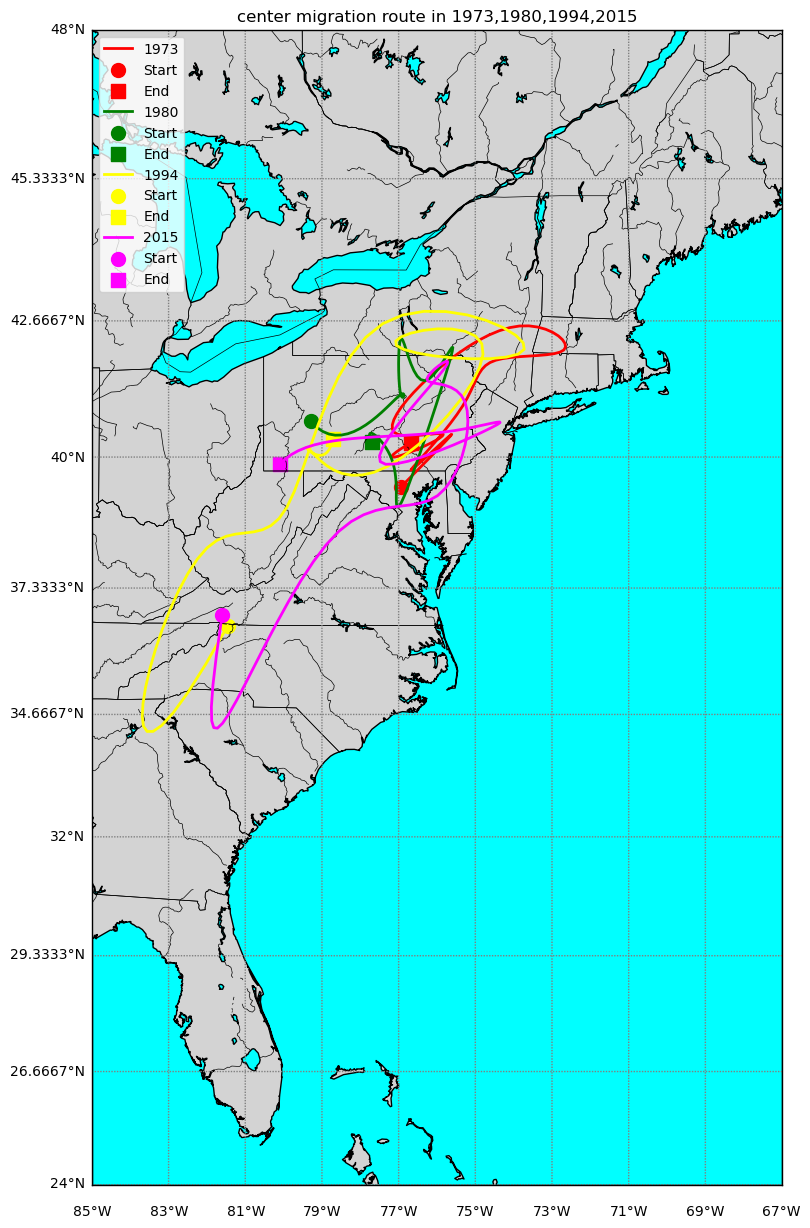

In [321]:
plt.figure(figsize=(15, 15))
m = Basemap(projection='merc', 
            llcrnrlat=24, urcrnrlat=48, 
            llcrnrlon=-85, urcrnrlon=-67, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawrivers()

m.drawparallels(
    np.linspace(24,48, 10), 
    labels=[1, 0, 0, 0],  
    fontsize=10, color='gray'
)
m.drawmeridians(
    np.linspace(-85, -67, 10), 
    labels=[0, 0, 0, 1],  
    fontsize=10, color='gray'
)

colors = ['red', 'green', 'yellow', 'magenta', 'orange', 'cyan']
years = [1973,1980,1994,2015]
for j in range(len(years)):
    x = []
    y = []
    for i in range((years[j]-1962)*12, (years[j]+1-1962)*12):
        x_i, y_i = m(centers_lon[i], centers_lat[i])
        x.append(x_i)
        y.append(y_i)  
    # m.plot(x, y, color='red', linewidth=2, marker='o', markersize=8)

    f = interp1d(np.arange(len(x)), np.array(list(zip(x, y))), kind='cubic', axis=0)

    new_points = f(np.linspace(0, len(x)-1, 100))

    m.plot(new_points[:, 0], new_points[:, 1], color=colors[j], linewidth=2,label = years[j])
    m.scatter(new_points[0, 0], new_points[0, 1], color=colors[j], marker='o', s=100, label='Start')
   
    m.scatter(new_points[-1, 0], new_points[-1, 1], color=colors[j], marker='s', s=100, label='End')
plt.title('center migration route in 1973,1980,1994,2015')
plt.legend()
plt.show()  

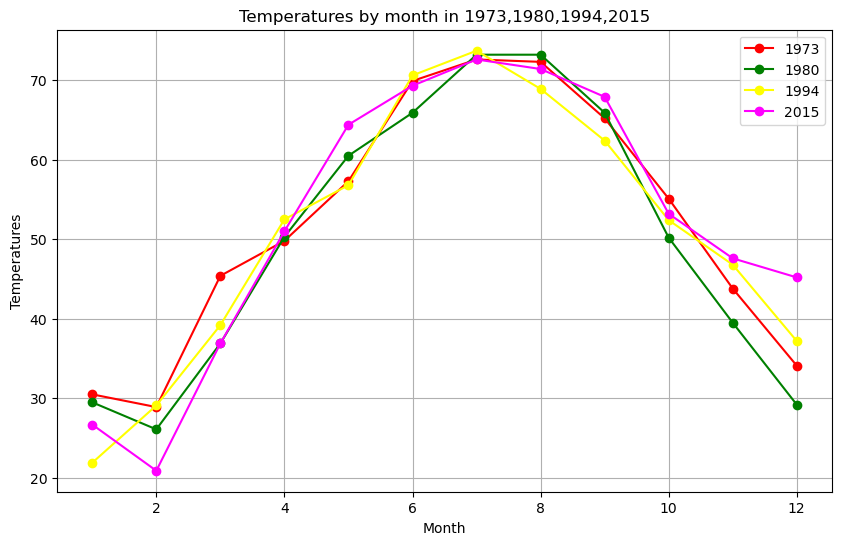

In [322]:
plt.figure(figsize=(10, 6))

for j in range(len(years)):
    plt.plot([i for i in range(1,13)],temperatures[(years[j]-1962)*12:(years[j]+1-1962)*12], label=years[j], color=colors[j], marker='o')

plt.xlabel('Month')
plt.ylabel('Temperatures')
plt.title('Temperatures by month in 1973,1980,1994,2015')

plt.legend()

plt.grid(True)

plt.show()